\begin{aligned}&\frac{dx}{dt}=2x+3y\\&\frac{dy}{dt}=-4y.\end{aligned}
$$x(0)=0\\y(0)=1$$


$$\begin{aligned}&x(t)=\frac{1}{2}e^{2t}-\frac{1}{2}e^{-4t}\\&y(t)=e^{-4t}.\end{aligned}$$

### 原始代码  
BsplineKANLayer

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
# from deepkan import SplineLinearLayer
from KAN import KANModel
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import nodepy.linear_multistep_method as lm
import torch.nn as nn
    
torch.set_default_dtype(torch.float64) # 设置默认张量数据类型为双精度浮点数

# define solution
sol_fun_1 = lambda x:  2 * x[:,[0]] + 3 * x[:,[1]] 
sol_fun_2 = lambda x:   - 4 * x[:,[1]] 

source_fun_1 = lambda t: 0.5*torch.exp(2*t) - 0.5*torch.exp(-4*t)
source_fun_2 = lambda t: torch.exp(-4*t) 


# Hyperparameter
n_steps = 1000            # 样本取点数     
steps = 2000               # 迭代次数
log = 1                   # 迭代序号
M = 1                     # 多步法的步数
y0 = np.array([0,1])      # 方程初始值
t_np = np.linspace(0, 10, num=n_steps)
dt = t_np[M] - t_np[0]   # 步长


def f(x,t): # x is 2 x 1
    A = np.array([[2,3], [0,-4]]) # 2 x 2
    f = np.matmul(A,x[:,None]) # 2 x 1
    return f.flatten()

# # 计算出微分方程的数值解，它使用 lsoda 方法进行数值积分，lsoda 方法使用了 Gear 公式的变步长、变阶数实现。它是一种隐式的多步法
# y_np = odeint(f, y0, t_np) 

# 计算微分方程的真实解
y_np1 = source_fun_1(torch.from_numpy(t_np))
y_np2= source_fun_2(torch.from_numpy(t_np))
y_np = torch.stack([y_np1, y_np2], axis=1).numpy()
y_train = y_np[0::M,:]


lamb = 0.1
model = KANModel(width=[2,5,2], grid_range=[0,81])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01,betas=(0.9, 0.999),  eps=1e-32)

def net_Y(alpha,beta,T,y_train_new):
    Y = alpha[0] * T[:, M:, :] + dt * beta[0] * model(y_train_new[M:, :]).unsqueeze(0)
    for m in range(1, M + 1):
        Y = Y + alpha[m] * T[:, M-m:-m, :] + dt * beta[m] * model(y_train_new[M-m:-m, :]).unsqueeze(0) # S x (N-M+1) x D
    return Y


# 用于存储每次迭代的损失值
Train_loss_list = []
Test_loss_list = []
iteration_list = []

for epoch in range(steps):
    model.train()
    scheme = 'AM'
        # Load weights
    switch = {'AM': lm.Adams_Moulton,
                'AB': lm.Adams_Bashforth,
                'BDF': lm.backward_difference_formula}
    method = switch[scheme](M)

    # 将 method.alpha 和 method.beta 转换为浮点数数组
    alpha = torch.tensor(-np.array(method.alpha[::-1], dtype=np.float32))
    beta = torch.tensor(np.array(method.beta[::-1], dtype=np.float32))

    y_train_new  = torch.tensor(y_train)
    T = y_train_new.unsqueeze(0)
    optimizer.zero_grad()
    Y_pred = net_Y(alpha,beta,T,y_train_new)
    loss = criterion(Y_pred, torch.zeros_like(Y_pred)) 
    l2loss = criterion(Y_pred, torch.zeros_like(Y_pred)) + lamb * model.reg(y_train_new)
    l2loss.backward()
    optimizer.step()
    
    # 测试集
    test_steps = 1000
    test_np = np.linspace(2, 4, num=test_steps)
    y_test_np1 = source_fun_1(torch.from_numpy(test_np))
    y_test_np2 = source_fun_2(torch.from_numpy(test_np))
    y_test_np = torch.stack([y_test_np1, y_test_np2], axis=1)
    f_test_1 =sol_fun_1(y_test_np)
    f_test_2 =sol_fun_2(y_test_np)
    f_test = torch.cat((f_test_1, f_test_2), dim=1).detach()
    f_nn= model(y_test_np).detach()
    Test_loss =  torch.mean((f_test - f_nn)**2)


    # 存储损失值和迭代次数
    Train_loss_list.append(loss.cpu().detach().numpy())
    Test_loss_list.append(Test_loss.cpu().detach().numpy())
    iteration_list.append(epoch)



    if epoch % 500 == 0:
        print(f'Epoch {epoch+1}/{steps}, Train_loss: {loss.item(): .16e},  Test_loss: {Test_loss.item(): .16e}')
        #   print(f'Epoch {epoch+1}/{steps}, loss: {loss.item(): .16e}')

Epoch 1/2000, Train_loss:  2.4573323079214160e+11,  Test_loss:  4.4759895497384743e+05
Epoch 501/2000, Train_loss:  3.9713263746679318e-06,  Test_loss:  4.9011076885354062e-02
Epoch 1001/2000, Train_loss:  2.9504338576328764e-06,  Test_loss:  1.5433342609210627e-02
Epoch 1501/2000, Train_loss:  2.8017338486372036e-06,  Test_loss:  1.1132171934405912e-02


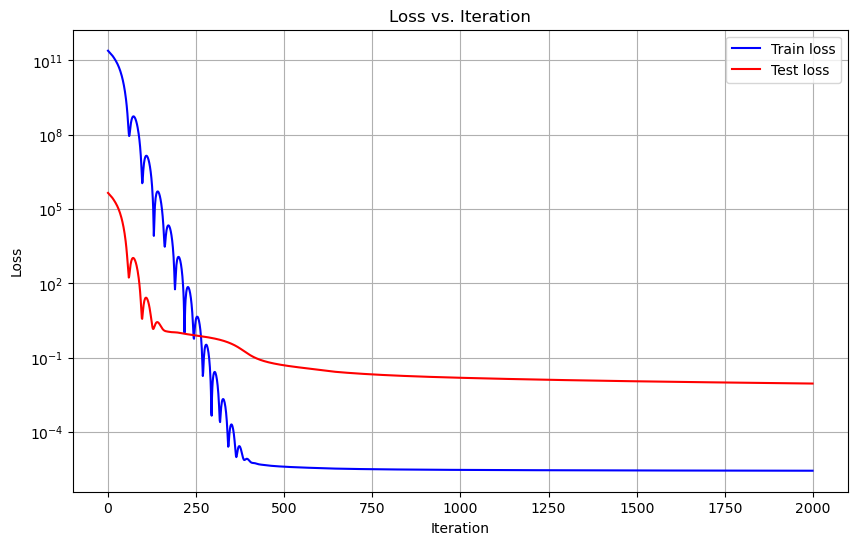

In [2]:
# Ploting
plt.figure(figsize=(10, 6))
plt.plot(iteration_list, Train_loss_list, label='Train loss', color='b')  # 绘制训练损失曲线，蓝色
plt.plot(iteration_list, Test_loss_list, label='Test loss', color='r')  # 绘制测试损失曲线，红色
plt.yscale('log')
# plt.ylim(10e-15, 10e1)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
test_steps = n_steps
test_np = np.linspace(0, 10, test_steps)
test_np_new = torch.linspace(0, 10, test_steps)


def predict_f(y_star):
    y_star_tensor = torch.tensor(y_star)
    with torch.no_grad():
        F_star = model(y_star_tensor)
    return F_star.numpy()

def learned_f(x,t):
    f = predict_f(x[None,:])
    return f.flatten()

learned_X_star = odeint(learned_f, y0, test_np) 
y_np1 = odeint(f, y0, test_np)  

lossx1 = np.max(learned_X_star[:,0]-source_fun_1(test_np_new).numpy())
lossx2 = np.max(learned_X_star[:,1]-source_fun_2(test_np_new).numpy())
print('x1_loss: {lossx1: .16e}, x2_loss: {lossx2: .16e}'.format(lossx1=lossx1, lossx2=lossx2))

x1_loss:  1.7023872000080347e+05, x2_loss:  1.0843660956619983e-02


<function matplotlib.pyplot.show(close=None, block=None)>

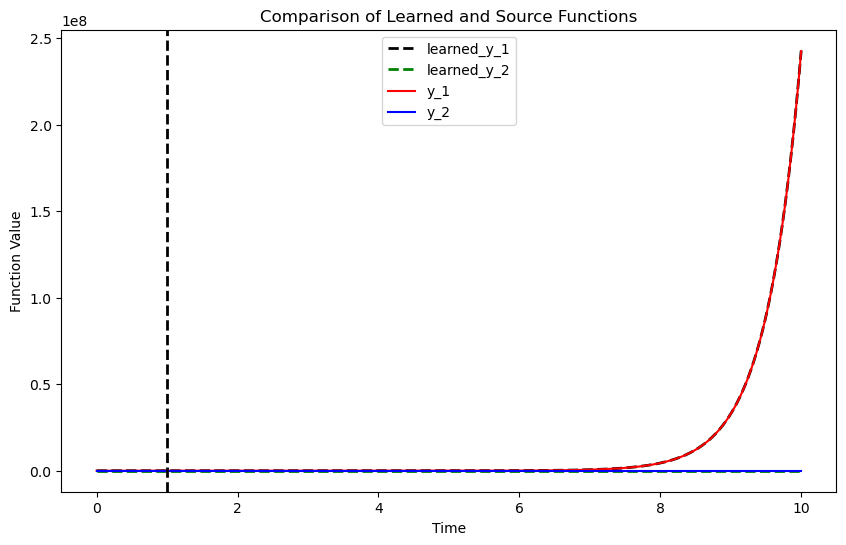

In [4]:
####### Plotting ################## 
#source_fun_1 = lambda t: 0.5*torch.exp(2*t) - 0.5*torch.exp(-4*t)
#source_fun_2 = lambda t: torch.exp(-4*t) semilogy

plt.figure(figsize=(10, 6))
plt.plot(test_np, learned_X_star[:,0], 'k--', label='learned_y_1',linewidth=2)
plt.plot(test_np, learned_X_star[:,1], 'g--', label='learned_y_2',linewidth=2)
plt.plot(test_np, source_fun_1(test_np_new), label='y_1', color='r')
plt.plot(test_np, source_fun_2(test_np_new), label='y_2', color='b')
plt.axvline(x=1, color='k', linestyle='--', linewidth=2)
# 添加图表标题和坐标轴标签
plt.title('Comparison of Learned and Source Functions')
plt.xlabel('Time')
plt.ylabel('Function Value')
plt.legend()
# plt.savefig('x_xnn1_1.png', format='png', dpi=600)
plt.show